Window: 330 samples (15ms)


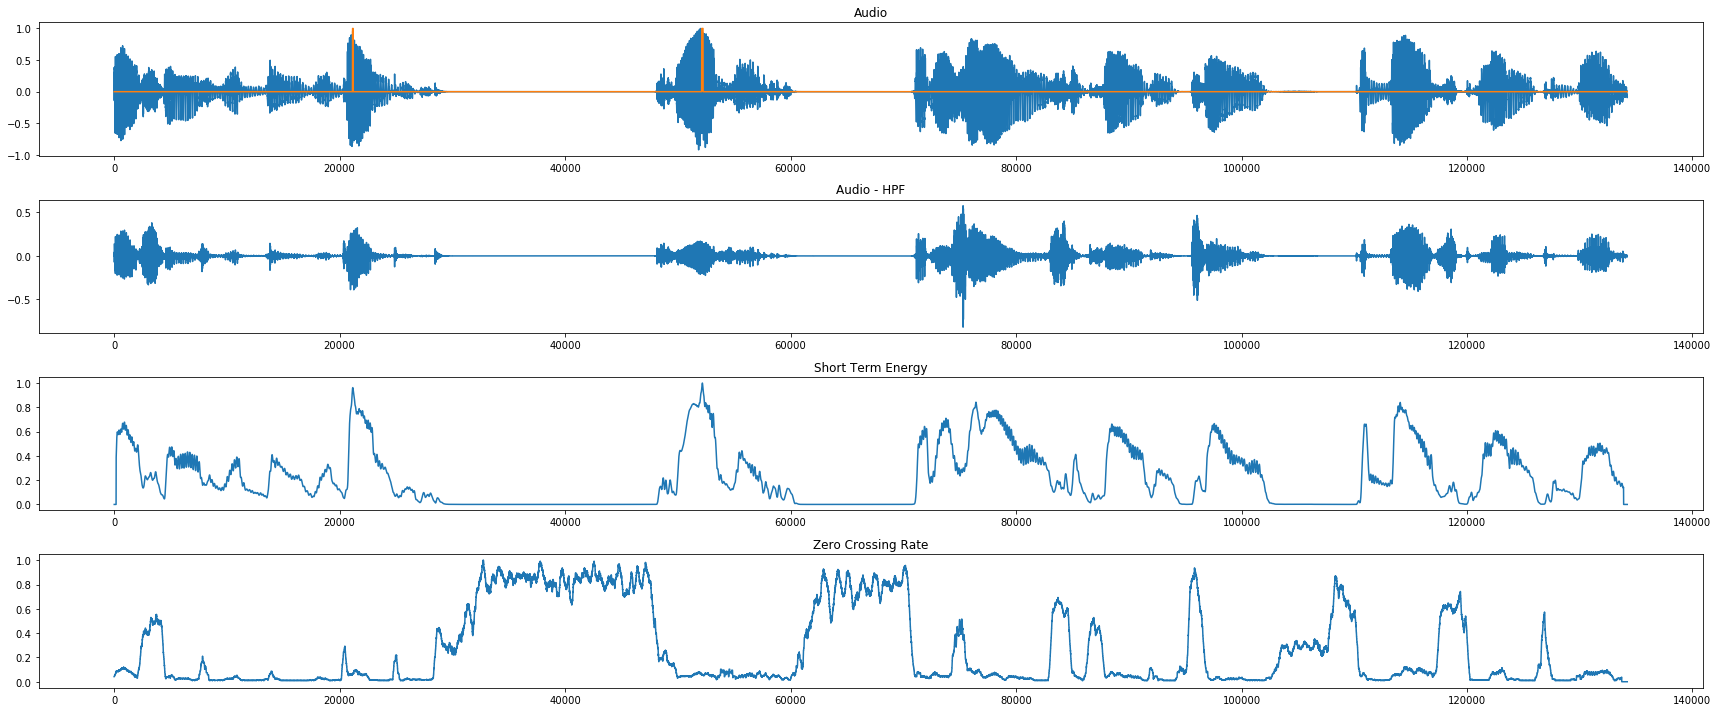

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import peakutils
import IPython.display

from scipy.signal import hamming, savgol_filter
from scipy.io import wavfile
from scipy import stats

# from listen.audio.segmentation import segments
from listen.spectrogram.spectrogram import Spectrogram
# from listen.data.librispeech import librispeech
from listen.data.an4 import an4

an4data = an4.AN4(conversion=False, debug=False)

# spg = Spectrogram(fft_size=2048, step_size=128, thresh=400)
train = list(an4data.trainset)
ch = random.choice(range(len(train)))
# ch = 179
# samples, t = train[ch]
samples = 'abk.wav'
# samples,t = librispeech.load_data(dev=True)[15]
# samples = 'D:\\theyenaman\\Dropbox\\code\\python\\ml_project\\listen\\data\\librispeech\\LibriSpeech\\dev-clean\\84\\121123\\84-121123-0020.wav'
rate, data = wavfile.read(samples)
c = np.random.randint(0, 100)
st =  c * (len(data) // 100)
en = (c + 2) * (len(data) // 100)
data = data[st:en]
# min_duration = int((1000 * len(data) / rate) / (20 * len(t) + 20))
min_duration = 15
wsize = (rate * min_duration) // 1000
if wsize % 2 == 1:
    wsize += 1

N = len(data)
alpha = 0.95
window = hamming(wsize)
print("Window: {} samples ({}ms)".format(wsize, min_duration))

data = data/ np.max(data)
zcr = np.zeros_like(data)
ste = np.zeros_like(data)
decision = np.zeros_like(data)
xs = np.zeros_like(data, dtype=np.float32)

for i in range(N - 1):
    xs[i] = data[i].astype(np.float32) - alpha * data[i + 1].astype(np.float32)

xs_ = np.r_[[0] * (wsize // 2) , data, [0] * (wsize // 2)]
for i in range(wsize //2, N - wsize):
    ste[i] = np.linalg.norm(xs_[i - wsize //2: i + wsize //2] * window, 2)

for i in range(wsize //2, N - wsize - 1):
    s = np.sign(xs_[i + 1 - wsize //2: i + wsize //2 + 1]) - np.sign(xs_[i - wsize //2: i + wsize //2])
    np.clip(s, -1, 1, out=s)
    zcr[i - wsize //2] = np.sum(np.abs(s))

me = np.max(ste)
mz = np.max(zcr)
a = 0.05
tel = a * me
tzl = a * mz
teu = (1 - a) * me
tzu = (1 - a) * mz

for i in range(N):
    if ste[i] > teu:
        decision[i] = 1
    
ste = ste / np.max(ste)
zcr = zcr / np.max(zcr)

fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(24, 10))
ax[0].plot(data)
ax[0].set_title('Audio')
ax[1].plot(xs)
ax[1].set_title('Audio - HPF')
ax[2].plot(ste)
ax[2].set_title('Short Term Energy')
ax[3].plot(zcr)
ax[3].set_title('Zero Crossing Rate')
ax[0].plot(decision)
fig.tight_layout()
plt.show()
IPython.display.Audio(data=data, rate=rate)
# IPython.display.Audio(data=xs, rate=rate)